# ITB Building Recognition

In [0]:
import h5py
import pandas as pd
import numpy as np
import keras
import imgaug as ia
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import cv2

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Loading Data
I have resized the image to 224 x 224 since it isn't too big and many good CNN architecture use that size

In [0]:
data_filename = '/content/drive/My Drive/ITB Building Classification/resized_data.h5'

data_file = h5py.File(data_filename, 'r')
X, y = np.array(data_file['image'].value), np.array(data_file['label'].value)

In [0]:
buildings = {0: 'Perpustakaan',
                 1: 'Labtek_V',
                 2: 'Oktagon',
                 3: 'TVST',
                 4: 'Aula_Timur',
                 5: 'Labtek_VII',
                 6: 'Aula_Barat',
                 7: 'Labtek_VIII',
                 8: 'CC_Barat',
                 9: 'Labtek_VI',
                 10: 'PAU',
                 11: 'CC_Timur'}
unique, counts = np.unique(y, return_counts=True)
print('Total image before augmentation :', len(y))
print(dict(zip(buildings.values(), counts)))

Total image before augmentation : 3583
{'Perpustakaan': 337, 'Labtek_V': 440, 'Oktagon': 683, 'TVST': 183, 'Aula_Timur': 150, 'Labtek_VII': 288, 'Aula_Barat': 300, 'Labtek_VIII': 176, 'CC_Barat': 285, 'Labtek_VI': 309, 'PAU': 247, 'CC_Timur': 185}


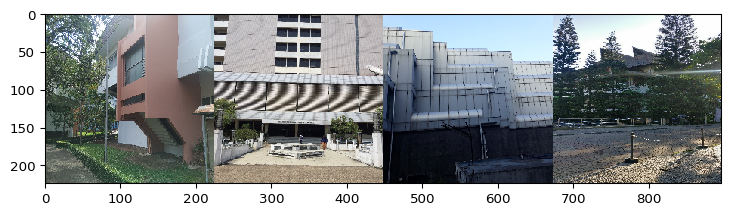

['Oktagon', 'PAU', 'Perpustakaan', 'Labtek_VI']


In [0]:
rndm = (np.random.random(4)*3583).astype(int)
ia.imshow(np.hstack(X[rndm]))
print([buildings[i] for i in y[rndm]])

Train test split is performed before augmentation to prevent data leaking

In [0]:
y = keras.utils.to_categorical(y, dtype='float32')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=500, stratify=y)

print('Train image shape :', X_train.shape)
print('Test image shape :', X_test.shape)
print('Train label shape :', y_train.shape)
print('Test label shape :', y_test.shape)

Train image shape : (3083, 224, 224, 3)
Test image shape : (500, 224, 224, 3)
Train label shape : (3083, 12)
Test label shape : (500, 12)


## Augmentation
I choose to zoom in and increasing/decreasing brightness augmentation because they don't hurt image quality. And I don't use horizontal flipping because a few building like Labtek V-VII and Aula Barat-Timur is very similar, horizontal flipping will make it harder to recognize

In [0]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=[0.5, 1],
    brightness_range=[0.8, 1.2],
    horizontal_flip=False,
    validation_split=0.16)

bs = 32
train_generator = train_datagen.flow(X_train, y_train, batch_size=bs, subset='training')
valid_generator = train_datagen.flow(X_train, y_train, batch_size=bs, subset='validation')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 3083 + 1) instead
  """Entry point for launching an IPython kernel.


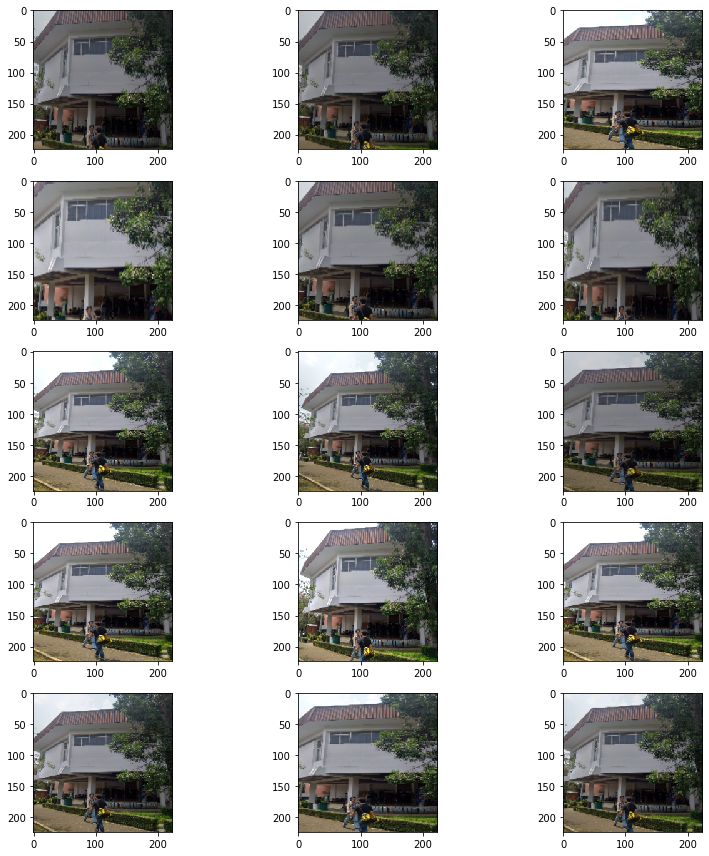

['Oktagon']


In [0]:
rndm = np.random.random_integers(0, 3083)
X_ex, y_ex = X_train[rndm].reshape((1, 224, 224, 3)), y_train[rndm].reshape((1, 12))
example_generator = train_datagen.flow(X_ex, y_ex)
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()
print([buildings[i] for i in np.where(y_ex == 1.)[1]])

## Modelling
I choose pre-trained DenseNet on ImageNet dataset because it has good performance but the parameters are not too many so that training time is not long

### DenseNet121

In [0]:
dense121 = keras.applications.densenet.DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet', input_tensor=None, pooling='avg')
output = keras.layers.Dense(12, activation = 'softmax')(dense121.output)
dense121 = keras.models.Model(inputs = dense121.inputs, outputs = output)

dense121.summary()














Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________

In [0]:
dense121.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = dense121.fit_generator(train_generator, epochs=30, steps_per_epoch=2583//bs, validation_data=valid_generator, validation_steps=500//bs, callbacks=[early_stopping_cb])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
80/80 [==============================] - 87s 1s/step - loss: 0.8173 - acc: 0.7337 - val_loss: 7.3444 - val_acc: 0.2333
Epoch 2/30
80/80 [==============================] - 51s 635ms/step - loss: 0.3475 - acc: 0.8816 - val_loss: 1.7206 - val_acc: 0.5640
Epoch 3/30
80/80 [==============================] - 50s 625ms/step - loss: 0.2163 - acc: 0.9269 - val_loss: 1.2808 - val_acc: 0.7158
Epoch 4/30
80/80 [==============================] - 50s 623ms/step - loss: 0.2579 - acc: 0.9179 - val_loss: 3.8874 - val_acc: 0.3623
Epoch 5/30
80/80 [==============================] - 50s 627ms/step - loss: 0.1937 - acc: 0.9304 - val_loss: 1.7138 - val_acc: 0.5987
Epoch 6/30
80/80 [==============================] - 50s 624ms/step - loss: 0.1547 - acc: 0.9492 - val_loss: 0.2448 - val_acc: 0.9132
Epoch 7/30
80/80 [==============================] - 50s 626ms/step - loss: 0.1064 - acc: 0.9637 - val_loss:

In [0]:
def plot(history):
  history_df = pd.DataFrame(history.history)
  history_df[['acc', 'val_acc']].plot()
  plt.show()

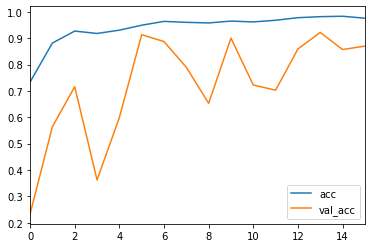

In [0]:
plot(history)

In [0]:
dense121.evaluate(X_test/255., y_test)

500/500 [==============================] - 4s 7ms/step


[0.20143950092792512, 0.934]

In [0]:
def TTA(model, datagen, X_test, y_test, tta_steps=10):
  predictions = []

  for i in range(tta_steps):
    print(i)
    preds = model.predict_generator(test_datagen.flow(X_test, batch_size=1, shuffle=False), steps = len(X_test)/1)
    predictions.append(preds)

  pred = np.mean(predictions, axis=0)

  print('TTA acc :', np.mean(np.equal(np.argmax(y_test, axis=-1), np.argmax(pred, axis=-1))))

  return pred

In [0]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=[0.5, 1],
    brightness_range=[0.8, 1.2],
    horizontal_flip=False)

pred = TTA(dense121, test_datagen, X_test, y_test, 10)

0
1
2
3
4
5
6
7
8
9
TTA acc : 0.932


### DenseNet169

In [0]:
dense169 = keras.applications.densenet.DenseNet169(input_shape=(224, 224, 3), include_top=False, weights='imagenet', input_tensor=None, pooling='avg')
output = keras.layers.Dense(12, activation = 'softmax')(dense169.output)
dense169 = keras.models.Model(inputs = dense169.inputs, outputs = output)

dense169.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [0]:
dense169.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = dense169.fit_generator(train_generator, epochs=30, steps_per_epoch=2583//bs, validation_data=valid_generator, validation_steps=500//bs, callbacks=[early_stopping_cb])

Epoch 1/30
80/80 [==============================] - 101s 1s/step - loss: 0.8172 - acc: 0.7310 - val_loss: 2.4658 - val_acc: 0.5646
Epoch 2/30
80/80 [==============================] - 56s 705ms/step - loss: 0.3917 - acc: 0.8705 - val_loss: 6.3184 - val_acc: 0.3124
Epoch 3/30
80/80 [==============================] - 57s 710ms/step - loss: 0.2897 - acc: 0.9042 - val_loss: 1.1526 - val_acc: 0.7093
Epoch 4/30
80/80 [==============================] - 57s 707ms/step - loss: 0.1954 - acc: 0.9355 - val_loss: 0.8958 - val_acc: 0.7636
Epoch 5/30
80/80 [==============================] - 56s 705ms/step - loss: 0.2130 - acc: 0.9312 - val_loss: 0.5942 - val_acc: 0.7852
Epoch 6/30
80/80 [==============================] - 56s 699ms/step - loss: 0.1751 - acc: 0.9371 - val_loss: 0.6619 - val_acc: 0.8395
Epoch 7/30
80/80 [==============================] - 56s 694ms/step - loss: 0.1420 - acc: 0.9554 - val_loss: 1.5359 - val_acc: 0.6725
Epoch 8/30
80/80 [==============================] - 55s 693ms/step - lo

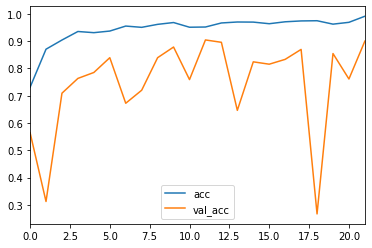

In [0]:
plot(history)

In [0]:
dense169.evaluate(X_test/255., y_test)

500/500 [==============================] - 3s 7ms/step


[0.2963307571411133, 0.9139999995231628]

In [0]:
pred = TTA(dense169, test_datagen, X_test, y_test, 10)

0
1
2
3
4
5
6
7
8
9
TTA acc : 0.94


### DenseNet201

In [0]:
dense201 = keras.applications.densenet.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights='imagenet', input_tensor=None, pooling='avg')
output = keras.layers.Dense(12, activation = 'softmax')(dense201.output)
dense201 = keras.models.Model(inputs = dense201.inputs, outputs = output)

dense201.summary()














74842112/74836368 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________

In [0]:
dense201.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = dense201.fit_generator(train_generator, epochs=30, steps_per_epoch=2583//bs, validation_data=valid_generator, validation_steps=500//bs, callbacks=[early_stopping_cb])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/30
80/80 [==============================] - 134s 2s/step - loss: 0.8218 - acc: 0.7357 - val_loss: 7.5240 - val_acc: 0.2646
Epoch 2/30
80/80 [==============================] - 61s 767ms/step - loss: 0.3767 - acc: 0.8738 - val_loss: 1.3923 - val_acc: 0.6356
Epoch 3/30
80/80 [==============================] - 61s 758ms/step - loss: 0.2799 - acc: 0.9062 - val_loss: 1.5387 - val_acc: 0.7050
Epoch 4/30
80/80 [==============================] - 61s 759ms/step - loss: 0.2268 - acc: 0.9234 - val_loss: 0.5780 - val_acc: 0.8395
Epoch 5/30
80/80 [==============================] - 61s 761ms/step - loss: 0.1923 - acc: 0.9359 - val_loss: 1.1904 - val_acc: 0.7375
Epoch 6/30
80/80 [==============================] - 61s 759ms/step - loss: 0.1817 - acc: 0.9390 - val_loss: 0.8501 - val_acc: 0.8330
Epoch 7/30
80/80 [==============================] - 60s 753ms/step - loss: 0.1499 - acc: 0.9539 - val_loss: 

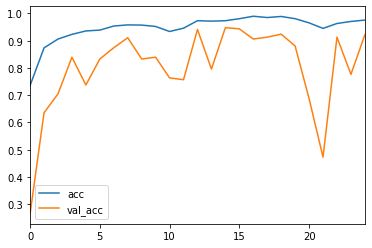

In [0]:
plot(history)

In [0]:
dense201.evaluate(X_test/255., y_test)

500/500 [==============================] - 15s 31ms/step


[0.17033969792723655, 0.94]

In [0]:
pred = TTA(dense201, test_datagen, X_test, y_test, 10)

0
1
2
3
4
5
6
7
8
9
TTA acc : 0.97


Test time augmentation increase accuracy significantly.
0.97 accuracy is very good, I even hard to distinguish Labtek V-VII

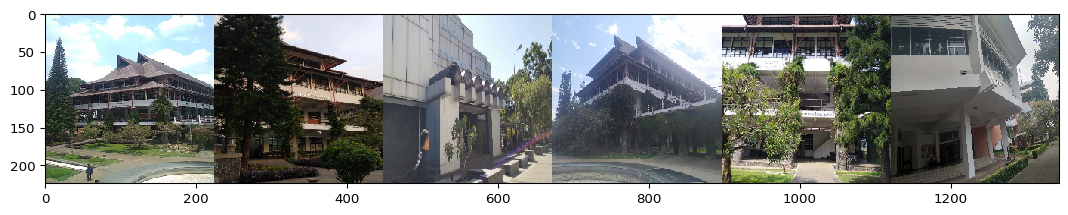

Predictions :  ['Labtek_VII', 'Labtek_VII', 'Perpustakaan', 'Labtek_V', 'Labtek_VI', 'TVST']
Probability :  [0.9998385  0.9898518  0.95188034 0.9967023  0.99581593 0.9533661 ]
Actual :  ['Labtek_VII', 'Labtek_VII', 'Perpustakaan', 'Labtek_V', 'Labtek_VI', 'TVST']


In [0]:
rndm = (np.random.random(6)*500).astype(int)
ia.imshow(np.hstack(X_test[rndm]))
print('Predictions : ', [buildings[i] for i in np.argmax(pred, axis=-1)[rndm]])
print('Probability : ', np.max(pred[rndm], axis=1))
print('Actual : ', [buildings[i] for i in np.argmax(y_test, axis=-1)[rndm]])

## Visualization (Grad-CAM)

In [0]:
rndm = (np.random.random(1)*500).astype(int)
pred = dense201.predict(X_test[rndm]/255.)
print("Prediction : ", np.argmax(pred[0]))
print("Probability : ", pred)

Prediction :  2
Probability :  [[3.3707856e-04 1.5768601e-04 9.9882668e-01 1.2483844e-06 5.3900534e-05
  8.0288783e-06 7.1059367e-06 7.6910837e-06 2.7298418e-06 2.9232181e-06
  4.5647412e-06 5.9045752e-04]]


In [0]:
oktagon_output = dense201.output[:, 2]
last_conv_layer = dense201.get_layer('relu')
grads = K.gradients(oktagon_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([dense201.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([X_test[rndm]/255.])
for i in range(1920):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  
heatmap = np.mean(conv_layer_output_value, axis=-1)

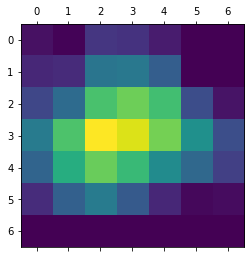

In [0]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [0]:
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * (1 - heatmap)), cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + 0.6 * X_test[rndm].reshape(224, 224, 3)

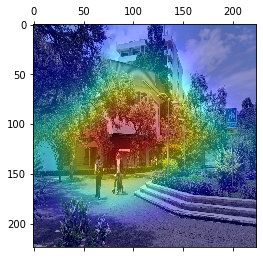

In [0]:
plt.matshow(superimposed_img.astype(np.uint8))